# Возможности работы в экосистеме `Hugging Face`

## Импорт

Экосистема [`Hugging Face`](https://huggingface.co) - это большое сообщество разработчиков инструментов, позволяющих пользователям создавать, обучать и внедрять модели машинного обучения на основе открытого кода и технологий. `HuggingFace` позволяет легко обмениваться инструментами, моделями, весами моделей и наборами данных между другими практикующими специалистами с помощью своего инструментария. 

Одной из основных особенностей экосистемы [`Hugging Face`](https://huggingface.co) является реализация наиболее продвинутых архитекутр нейронных сетей в концепции высокого уровня `API` и вспомогательных бибилотек для них. 

[В первую очередь](https://wandb.ai/int_pb/huggingface/reports/An-Introduction-To-HuggingFace-Transformers-for-NLP--VmlldzoyOTgzMjI5) `Hugging Face` ориентирован на работу с текстами. Однако сегодня это также и работа с изображениями и другими модальностями, а также вомзожности работы с мультимодальными ахритектурами.

С точки зрения решения задач компьютерного зрения в экосистеме `Hugging Face` можно выделить такие библиотеки, как:
* [`transformers`](https://huggingface.co/docs/transformers/index) - для работы с моделями на основе трансформеров и других современных подходов;
* [`diffusers`](https://huggingface.co/docs/diffusers/index) - для работы с моделями на основе диффузии;
* [`datasets`](https://huggingface.co/docs/datasets/en/index) - для работы с наборами данных;
* [`hub`](https://huggingface.co/docs/huggingface_hub/guides/download) - для работы с пользовательскими проектами;
* [`timm`](https://huggingface.co/docs/timm/feature_extraction) - рассматриваемый ранее проект работы с предобученными свертоными архитектурами и архитектурами трансформерами для задач компьютерного зрения;
* [`optimum`](https://huggingface.co/docs/optimum/index) - проект по оптимизации моделей для различных типов вычеслительных устройств;
* [`peft`](https://huggingface.co/docs/peft/main/en/index) - библиотека для эффективного файнтюнинга моделей  при помощи таких алгроитмов, как [`LoRA`](https://huggingface.co/docs/peft/main/en/task_guides/image_classification_lora);
* [`evaluate`](https://huggingface.co/docs/evaluate/index) - библиотека основных метрик оценки результатов работы нейронных сетей.
* и многие другие.

Отметим, что `Hugging Face` построен на основе экосистемы `PyTorch`.

В качестве дополнительных материалов см. :
* Курс сообщества [`Hugging Face`](https://huggingface.co/learn/computer-vision-course/en/unit0/welcome/welcome) по компьютерному зрению и [примеры кода к нему](https://github.com/johko/computer-vision-course/tree/main/notebooks);
* Блог и примеры пользователей (по моделям) [`Hugging Face`](https://huggingface.co/docs/transformers/main/en/model_doc/vit#resources), а также [тут](https://huggingface.co/docs/transformers/en/notebooks#pytorch-cv) и примеры пользователей, например, [`GitHub`](https://github.com/NielsRogge/Transformers-Tutorials/);
* Примеры работы с моделями-трансформерами в задач компьютерного зрения при помощи библиотеки [`transformers`](https://huggingface.co/docs/transformers/tasks/image_classification);
* Примеры работы с наборами изображений в библиотеке [`datasets`](https://huggingface.co/docs/datasets/image_load);
* Примеры по работе с изображениями в бибилиотеке [`diffusers`](https://huggingface.co/docs/diffusers/tutorials/basic_training).


<img src="https://huggingface.co/datasets/hf-vision/course-assets/resolve/743a2a115b53f258c9e6bc7744534d9e03b8a124/CV_in_defintiion.png" width='500px'>

Отметим в ряде случаев необходимость авторизации в экосистеме для работы. Как правило это необходимо для работы с частными библиотеками. Авторизация может быть выполнена при помощи кода ниже.
```python
    from huggingface_hub import notebook_login
    notebook_login()
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install --quiet evaluate
# !pip install accelerate -U --quiet
# !pip install --quiet -U datasets
# !pip install --quiet -U peft

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# from huggingface_hub import notebook_login
from datasets import load_dataset, DatasetDict
from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import Trainer, TrainingArguments
import evaluate
import peft

# Перенос обучения для задачи классификации в `HF`

## Загрузка данных при помощи бибилотеки `datasets`

В данном примере воспользуемся изученным ранее набором данных пчелы и муравьи.

Загрузку данных произведем при помощи функции `download_and_extract_archive` из библиотеки `torchvision`.

In [8]:
import os
from torchvision.datasets.utils import download_and_extract_archive
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
root_directory = os.path.join(os.getcwd(),'data')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
dataset_directory = os.path.splitext(dataset_directory)[0]

download_and_extract_archive(url, root_directory)

Using downloaded and verified file: /Users/mvronkin/Yandex.Disk.localized/Компьютерное зрение/практики очные/Короткий CV COurse/data/hymenoptera_data.zip
Extracting /Users/mvronkin/Yandex.Disk.localized/Компьютерное зрение/практики очные/Короткий CV COurse/data/hymenoptera_data.zip to /Users/mvronkin/Yandex.Disk.localized/Компьютерное зрение/практики очные/Короткий CV COurse/data


Теперь преобразуем данные в формат `Hugging Face` при помощи функции `load_dataset` из библиотеки `datasets`.

Следует отметить, что `datasets` позволяет также загружать наборы данных напрямую с `Hugging Face Hub` или стандартные наборы данных. Однако, этот функционал оптимизирован под ОС Linux.

> Например [Oxford-IIIT Pets Dataset](https://huggingface.co/datasets/pcuenq/oxford-pets) может быть загружен как ```dataset = load_dataset('pcuenq/oxford-pets')``` на прямую с хаба. Или, например,  первые 5000 тренировочных изображений могут быть загружены из стандартных наборов как `load_dataset("food101", split="train[:5000]")`.

Так как в нашем случае набор данных имеет формат `image folder` (директории `train` и `test` и в них по классам директории).

In [9]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir=dataset_directory)

Resolving data files:   0%|          | 0/245 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/153 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [10]:
dataset['train'][0]

{'image': <PIL.Image.Image image mode=RGB size=768x512>, 'label': 0}

In [12]:
labels = dataset['train'].unique('label')
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}
print(len(labels),labels)

2 [0, 1]


Попробуем визуализировать набор данных.

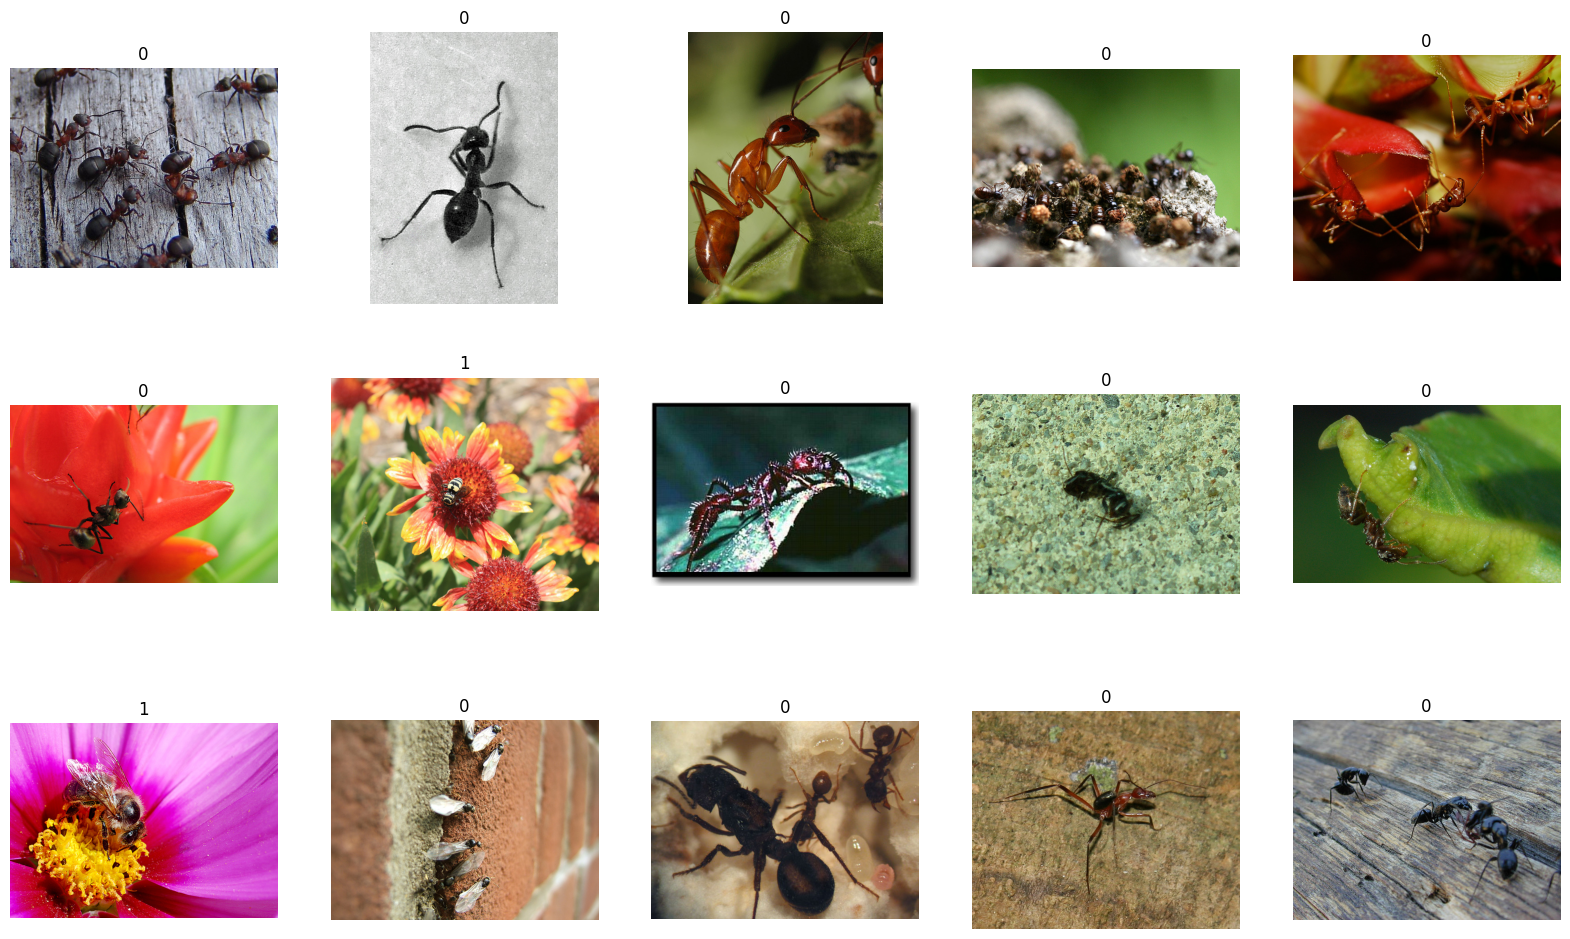

In [14]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
            
show_samples(dataset['train'],rows=3,cols=5)

Также проведем разделение набора данных на валидационный, тренировочный и тестовый.

В нашем случае эти части будут собраны в словарь типа `DatasetDict`.

In [15]:
split_dataset = dataset['train'].train_test_split(test_size=0.2) # 80% train, 20% evaluation
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5) # 50% validation, 50% test

dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 196
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 24
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 25
    })
})


Для того чтобы применить стратегию [`Transfer Learning`](https://huggingface.co/learn/computer-vision-course/en/unit3/vision-transformers/vision-transformers-for-image-classification) к выбранному набору данных, рекомендуется использовать преобразования данных, аналогичные таковым для предобученной модели. В данном примере рассмотрим модель [`google/vit-base-patch16-224`](https://huggingface.co/google/vit-base-patch16-224) из `Hugging Face hub`. Необходимые преобразования для модели можно получить при помощи модуля  [`AutoImageProcessor`](https://huggingface.co/docs/transformers/main_classes/image_processor) так, как это показано ниже.

In [17]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224', use_fast=True)
processor

ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Чтобы применить преобразования к батчу во время обучения, необходимо создать функцию, которая будет обрабатывать изображения во времения тренировки. Функцию можно задать при помощи метода `with_transform`.

 Для работы с батчами мы создадим функцию `transforms`, которая будет осуществлять следующие функции:
- Преобразование изображений в RGB: возможно, некоторые изображения в  наборе данных будут в тонах серого или прозрачными (RGBA).
- Преобразование строковых меток в целые числа: с помощью карты `label2id`.
- Применение преобразований изображений: мы передаем изображения через `processor` для обработки и конвертируем их в формат PyTorch.

В результате мы получим следующий вид набора данных:
``python
{
    'pixel_values': torch.Tensor,
    'labels': Список
}
```

In [18]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

processed_dataset = dataset.with_transform(transforms)

In [19]:
processed_dataset['train'][0]['pixel_values'].shape

torch.Size([3, 224, 224])

<blockquote>
    
Важно отметить, что предобработка данных может быть выполнена при помощи техник аугметнации [torchvision](https://pytorch.org/vision/stable/index.html). При этом отдельно могут быть созданы преобразования для любых частей набора данных.

```python
    import torchvision.transforms as T
    img_size = (224,224)

    train_tfms = T.Compose([
        T.Resize(img_size),
        T.RandomHorizontalFlip(),
        T.RandomRotation(30),
        T.CenterCrop(img_size),
        T.ToTensor(),
        T.Normalize(mean = (0.5,0.5,0.5),std = (0.5,0.5,0.5))])

    valid_tfms = T.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize(mean = (0.5,0.5,0.5), std = (0.5,0.5,0.5))])

    def train_transforms(batch):
        batch['image'] = [x.convert('RGB') for x in batch['image']]
        batch['pixel_values'] = [train_tfms(x) for x in batch['image']]
        batch['labels']=[label2id[y] for y in batch['label']]
        return batch

    def valid_transforms(batch):
        batch['image'] = [x.convert('RGB') for x in batch['image']]
        batch['pixel_values'] = [valid_tfms(x) for x in batch['image']]
        batch['labels']=[label2id[y] for y in batch['label']]
        return batch

    train_dataset = dataset['train'].with_transform(train_transforms)
    valid_dataset = dataset['validation'].with_transform(valid_transforms)
    test_dataset  = dataset['test'].with_transform(valid_transforms)
    len(train_dataset), len(valid_dataset), len(test_dataset)
```

## Тренировка модели

Перед началом работы с моделью также необходимо пакетирование  данных в правильном формате. Для этого возможным является создание специальной функции `collation`. В нашем случае для изображений (`pixel_values`) входная форма для модели должна быть (`batch, channels, height, width`), а для меток (`labels`) форма должна быть (`batch,`)

In [20]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])    
    }

<blockquote>

Также отметим, что подготовленный набор данных может быть преорабразован в формат `PyTorch`.
    
```python
    from torch.utils.data import DataLoader
    import torch

    train_dataloader = DataLoader(processed_dataset['train'], collate_fn=collate_fn, batch_size=4)

    batch = next(iter(train_dataloader))
    for k,v in batch.items():
      if isinstance(v, torch.Tensor):
        print(k, v.shape)
```

Для оценки результатов обучения создадим функцию оценки точности `accuracy` при помощи функционала библиотеки `evaluate`.

In [21]:
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

Теперь перейдем к загрузке модели. Для каждого типа моделей в transformers предусмотрен свой тип загрузки. Так, для моделей ViT будем использовать [`ViTForImageClassification`](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTForImageClassification). В данном случае будет загружена предобученная модель [`google/vit-base-patch16-224`](https://huggingface.co/google/vit-base-patch16-224), для которой предварительно были загружены преобразования. Оконечный слой модели будет заменен на новый, имеющий число выходов, равное количеству меток в наборе данных (аргумент `num_labels`). Также нужно передать `ignore_mismatched_sizes = True`, чтобы компенсировать изменение количества параметров в слое классификации.

In [22]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    ignore_mismatched_sizes = True
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Полученное предупреждение сообщает о необходимости дообучения модели так как последний слой заменен.

Так как в данном случае предполагается стратегия `Transfer Learning` придется заморозить все слои, кроме принимающих решение (`classifier`).

In [23]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

В этом можно убедиться, определив полное число параметров, и число обучаемых параметров.

In [24]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )
    
print_trainable_parameters(model)

trainable params: 1538 || all params: 85800194 || trainable%: 0.00


Также необходимо создать директорию для работы с результатами обучения. Так как в данном случае нет полноценной оптимизации под ОС Windows директорию лучше размещать как можно ближе к корню и по англоязычному пути.

In [34]:
import platform
from pathlib import Path
if platform.system() == "win32":
    path = Path(os.getcwd())
    root_directory = os.path.join(path.anchor, 'data')
else:
    home = str(Path.home())
    root_directory = os.path.join(home, 'data')

In [35]:
directory_save = os.path.join(root_directory, 'HFTrain')

if not os.path.exists(directory_save):
    os.makedirs(directory_save)
directory_save

'/Users/mvronkin/data/HFTrain'

Для самой тренировке модели можно воспользоваться объектом класса [Hugging Face Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer). Для этого объекта необходимо предварительно настроить обучение. Для этого можно использовать конфигуратор [`TrainingArguments`]() например так, как это показано ниже.

>Отметим, что для  классификации изображений,  необходимо установить `remove_unused_columns=False`, чтобы предотвратить удаление столбца `image` в нашем наборе данных, поскольку именно он используется для создания входных данных `pixel_values`.

In [46]:
training_args = TrainingArguments(
    output_dir=directory_save,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    use_cpu=True
)

training_args.device

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/training_args.py:1509: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


device(type='cpu')

In [47]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor)

In [48]:
trainer.train()

TrainOutput(global_step=65, training_loss=0.20111334874079778, metrics={'train_runtime': 81.0818, 'train_samples_per_second': 12.087, 'train_steps_per_second': 0.802, 'total_flos': 7.594214982230016e+16, 'train_loss': 0.20111334874079778, 'epoch': 5.0})

Теперь можно провести оценку результатов работы модели на тестовых данных.

In [49]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.14156106114387512,
 'eval_accuracy': 0.96,
 'eval_runtime': 1.9452,
 'eval_samples_per_second': 12.852,
 'eval_steps_per_second': 2.056,
 'epoch': 5.0}

Также можно визуализировать результаты.

In [53]:
def show_predictions(rows,cols, dataset = dataset['test'] ):
    samples = dataset.shuffle().select(np.arange(rows*cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # predicted labels from logits
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img = samples[i]['image']
        prediction = predictions[i]
        label = f"label: {samples[i]['label']}\npredicted: {id2label[prediction]}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

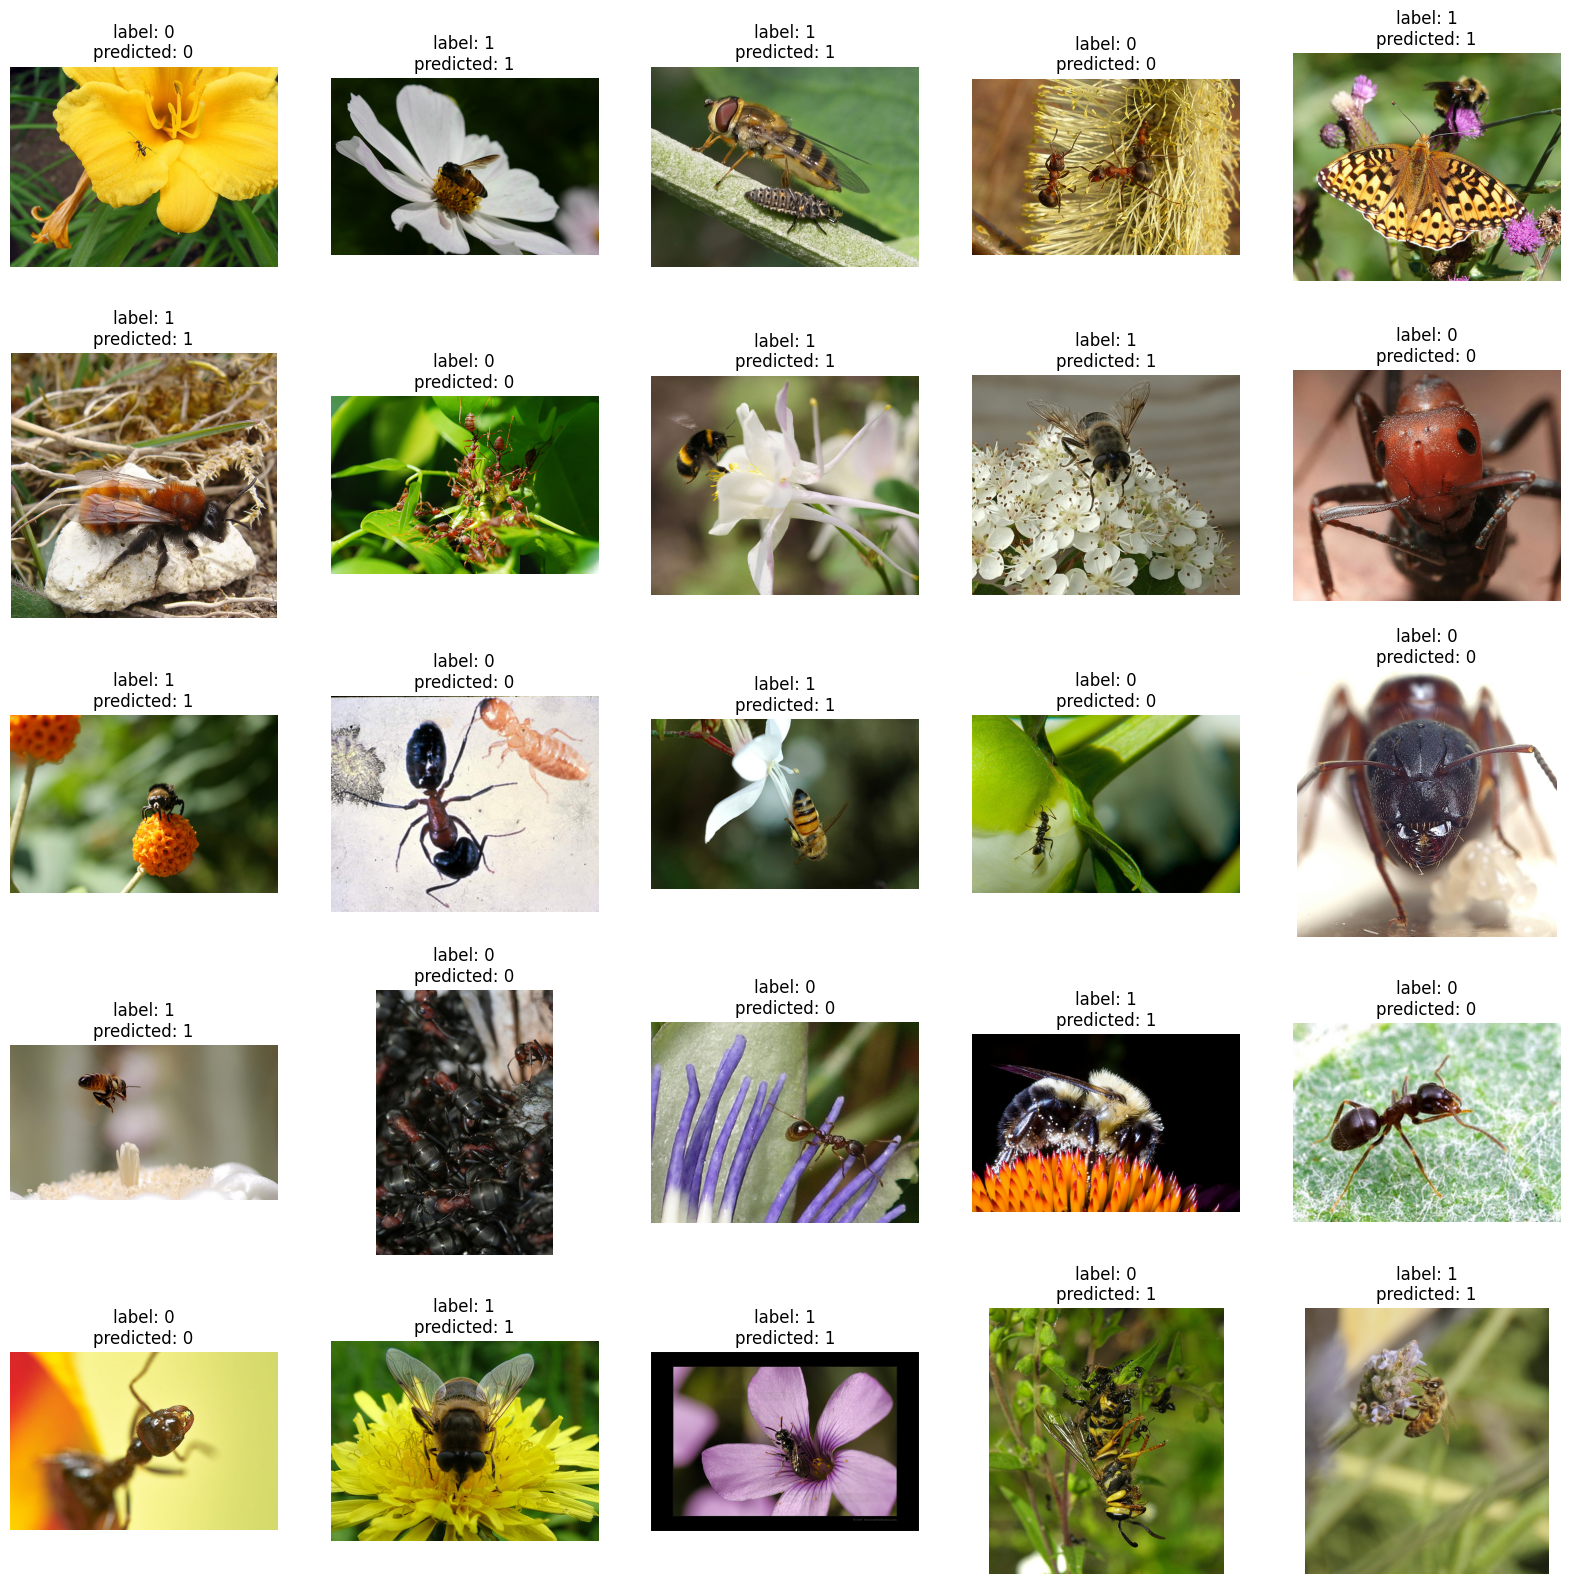

In [54]:
show_predictions(rows=5,cols=5)

## Задания

__1.__ Предлагается обучить модель, используя собственный пайплайн аугметнации вместо заданного из предобученной модели.

__2.__ Предлагается обучить другие модели `transformers`, например, [`MobileVit`](https://huggingface.co/apple/mobilevit-xx-small).

<code style='color:red'>__3.*__</code> Предлагается обучить модель для набора данных `CIFAR-10`, загруженного из стандартных наборов данных. 

```python

    train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
    # split up training into training + validation
    splits = train_ds.train_test_split(test_size=0.1)
    train_ds = splits['train']
    val_ds = splits['test']
```

<code style='color:red'>__4.*__</code> Предлагается создать свою головную часть для модели `VIT`, изученной в примерах.

<code style='color:red'>__5.*__</code> Помимо изученных ранее стратегий использования предобученных моделей в Hugging Face предлагается еще одна. Такую стратегию можно бы было называть оптимизацией `Fine Tuning`. Реализации этих стратегий могут быть найдены в библиотеке [`PEFT`](https://huggingface.co/docs/peft/en/index). Ниже приведен примеры работы модели с оптимизатором [`LoRA`](https://arxiv.org/abs/2106.09685)(Low-Rank Adaptation) для набора данных, который рассматривался в примерах.

> Отметим, что библиотека [`PEFT`](https://huggingface.co/docs/peft/en/index) в своей основе представляет собой метод оптимизации `Parameter-Efficient Fine-Tuning`, который подразумевает дообучение модели, [когда большенство параметров заморожено](https://habr.com/ru/articles/791966/).



<blockquote>

Метод [LoRA (Low-Rank Adaptation)](https://github.com/microsoft/LoRA) был разработан в 2021 году. [Его создатели были вдохновлены](https://habr.com/ru/articles/791966/) данной научной работой, в которой авторы отмечают, что, хотя базисные модели имеют миллионы или даже миллиарды параметров, они имеют низкую "внутреннюю размерность" (intrinsic dimension) при адаптации к новой задаче. Проще говоря, большинство параметров являются избыточными. Из чего можно сделать вывод, что матрицы можно представить пространством меньшей размерности, сохраняя при этом большую часть важной информации.

Создатели LoRA предположили, что изменение весов при файнтюнинге модели имеет низкий "внутренний ранг" (intrinsic rank). Идея данного метода заключается в том, что для предварительно обученной матрицы весов мы представляем её обновление двумя меньшими матрицами, полученными путем низкоранговой аппроксимации. Эти матрицы мы тренируем при обучении, а исходную матрицу весов замораживаем. Затем для получения окончательного результата мы объединяем исходные и обученные веса.

Одним из важнейших параметров является параметр "r" (ранг). Он определяет размер матриц низкого ранга. При правильном выборе ранга данный метод может показать впечатляющие результаты.



<img src="https://habrastorage.org/getpro/habr/upload_files/edd/f88/ff0/eddf88ff00409fa19ff21826a26e90d2.gif" width="500px">
</blockquote>

In [55]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    ignore_mismatched_sizes = True
)
print_trainable_parameters(model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 85800194 || all params: 85800194 || trainable%: 100.00


In [57]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 591362 || all params: 86391556 || trainable%: 0.68


In [59]:
args = TrainingArguments(
    output_dir=directory_save,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    label_names=["labels"],
    use_cpu = True
)

In [60]:
trainer = Trainer(
    model,
    args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

train_results = trainer.train()

In [124]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.009470988065004349,
 'eval_accuracy': 1.0,
 'eval_runtime': 9.5027,
 'eval_samples_per_second': 2.631,
 'eval_steps_per_second': 0.21,
 'epoch': 4.62}

__Предлагается__ решить задачу оптмизации для набора данных `CIFAR-10` при помощи оптимизации `LoRA`.

<code style='color:red'>__6.*__</code>

https://huggingface.co/docs/transformers/en/tasks/zero_shot_image_classification

In [61]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

checkpoint = "openai/clip-vit-large-patch14"

model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [65]:
from transformers import pipeline
checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [78]:
from PIL import Image
import requests
images = [dataset['test'][i]['image'] for i in range(3)]
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

predictions = detector(images, candidate_labels=["ant", "bee"])
predictions

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[[{'score': 0.9998961687088013, 'label': 'ant'},
  {'score': 0.00010377352737123147, 'label': 'bee'}],
 [{'score': 0.8276938199996948, 'label': 'bee'},
  {'score': 0.17230619490146637, 'label': 'ant'}],
 [{'score': 0.999397873878479, 'label': 'ant'},
  {'score': 0.0006020820583216846, 'label': 'bee'}]]

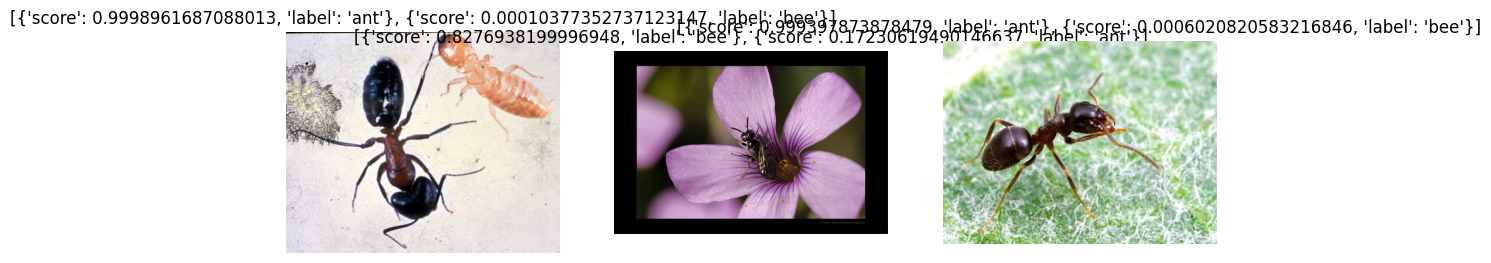

In [81]:
fig, axs = plt.subplots(1,3,figsize=(12,3));
for ax, im, pred in zip(axs,images,predictions):
    ax.imshow(np.array(im));ax.set_axis_off(); 
    pred =
    ax.set_title(pred)

plt.show()

In [62]:
def transforms_zs(batch):
    candidate_labels = ["bee", "ants"]
    candidate_labels = [f'This is a photo of {label}.' for label in candidate_labels]
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'], text=candidate_labels,return_tensors='pt', padding=True)
#     inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

processed_dataset = dataset.with_transform(transforms_zs)

In [63]:
processed_dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 196
})